# **A Scalable Deep Learning Solution for Multiclass Classification of Book Covers**

---

## Preliminary settings

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.random import set_seed

os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

KAGGLE_DATASET_NAME = "mohamedbakhet/amazon-books-reviews"
KAGGLE_DATASET_FOLDER = "kaggle_dataset/"

SEED = 42
np.random.seed(SEED)
set_seed(SEED)

!mkdir $KAGGLE_DATASET_FOLDER
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


## Dataset creation and preprocessing

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

def kaggle_download_files(dataset_name, directory_path="datasets/"):
    kaggle_api = KaggleApi()
    kaggle_api.authenticate()
    kaggle_api.dataset_download_files(dataset_name, path=directory_path, unzip=True)

kaggle_download_files(KAGGLE_DATASET_NAME, KAGGLE_DATASET_FOLDER)

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews


In [ ]:
from ast import literal_eval

def str_to_list(x):
    try: return tuple(literal_eval(x))
    except: return None

df = pd.read_csv(KAGGLE_DATASET_FOLDER + "books_data.csv", engine="python", on_bad_lines="skip", converters={"categories": str_to_list, "authors": str_to_list}, usecols=["Title", "authors", "image", "categories"])
print(len(df))
df.dropna(inplace=True)
print(len(df))

212404
147645


In [ ]:
len([(x, y) for x, y in df["categories"].value_counts().items() if len(x) > 1]) # No book has more than one category

0

In [ ]:
df["categories"] = df["categories"].apply(lambda x: x[0] if x and type(x) == tuple else None)
df.sample(5)

,Title,authors,image,categories
41681,Diplomatic Crime,"(Charles R. Ashman, Pamela Trescott)",http://books.google.com/books/content?id=8Jc6A...,Law
176221,My life in art (Soviet arts),"(Konstantin Stanislavsky,)",http://books.google.com/books/content?id=WtsLA...,Actors
106007,Red Mesa : An Ella Clah Novel,"(Aimée Thurlo, David Thurlo)",http://books.google.com/books/content?id=mmDOA...,Fiction
20282,Victorious Woman! Shaping Life's Challenges in...,"(Annmarie Kelly,)",http://books.google.com/books/content?id=PyXQP...,Self-Help
152911,A Perfect Scoundrel (Lords of Love),"(Heather Cullman,)",http://books.google.com/books/content?id=1htpB...,Fiction


In [ ]:
print(len(df["categories"].unique()))
cumulative_freq = df["categories"].value_counts(ascending=True, normalize=True).cumsum()
cumulative_freq[cumulative_freq >= 0.5]

7276


,proportion
categories,
Education,0.509919
Science,0.526777
Juvenile Nonfiction,0.548390
Social Science,0.573416
Computers,0.602086
Business & Economics,0.639107
Biography & Autobiography,0.680931
Juvenile Fiction,0.723980
History,0.785011


In [ ]:
N_ELEMENTS_PER_CATEGORY = 2200

filtered_categories = df["categories"].value_counts().loc[lambda x: x >= N_ELEMENTS_PER_CATEGORY].keys().to_list()
df = df[df["categories"].isin(filtered_categories)]

In [ ]:
df["categories"].value_counts()

,count
categories,
Fiction,22610
Religion,9132
History,9011
Juvenile Fiction,6356
Biography & Autobiography,6175
Business & Economics,5466
Computers,4233
Social Science,3695
Juvenile Nonfiction,3191


In [ ]:
N_CLASSES = len(filtered_categories)
N_CLASSES

12

In [ ]:
df['categories'].unique()

array(['Biography & Autobiography', 'Religion', 'Fiction',
       'Juvenile Nonfiction', 'History', 'Cooking', 'Social Science',
       'Juvenile Fiction', 'Science', 'Business & Economics', 'Computers',
       'Education'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

category_enc = LabelBinarizer()
category_enc.fit(df['categories'].unique())
categories_names = category_enc.classes_

df["onehot_categories"] = category_enc.transform(df["categories"]).tolist()
df

,Title,authors,image,categories,onehot_categories
1,Dr. Seuss: American Icon,"(Philip Nel,)",http://books.google.com/books/content?id=IjvHQ...,Biography & Autobiography,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Wonderful Worship in Smaller Churches,"(David R. Ray,)",http://books.google.com/books/content?id=2tsDA...,Religion,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,Whispers of the Wicked Saints,"(Veronica Haddon,)",http://books.google.com/books/content?id=aRSIg...,Fiction,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
5,The Church of Christ: A Biblical Ecclesiology ...,"(Everett Ferguson,)",http://books.google.com/books/content?id=kVqRa...,Religion,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
8,Saint Hyacinth of Poland,"(Mary Fabyan Windeatt,)",http://books.google.com/books/content?id=lmLqA...,Biography & Autobiography,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
212390,Petit Connoisseur: Art,"(Karen Salmansohn,)",http://books.google.com/books/content?id=MbSSO...,Juvenile Nonfiction,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
212394,Final things,"(Jenny Offill,)",http://books.google.com/books/content?id=UbSFB...,Fiction,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
212398,Autodesk Inventor 10 Essentials Plus,"(Daniel Banach, Travis Jones)",http://books.google.com/books/content?id=zxHRC...,Computers,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
212399,The Orphan Of Ellis Island (Time Travel Advent...,"(Elvira Woodruff,)",http://books.google.com/books/content?id=J7M-N...,Juvenile Fiction,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [ ]:
category_enc.transform(df["categories"][:3])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [ ]:
category_enc.transform(["Computers"])

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
def one_hot_to_str(x):
    return str(category_enc.inverse_transform(np.array([x]))[0])

one_hot_to_str(df["onehot_categories"].iloc[0])

'Biography & Autobiography'

In [ ]:
train_set, test_set = [pd.DataFrame() for _ in range(2)]
i_seed = 0

def split_group_train_val_test(group, train_frac=.8):
    from math import floor
    global train_set, test_set
    global i_seed

    group = group.sample(frac=1, random_state=SEED + i_seed).reset_index(drop=True)
    train_size = floor(N_ELEMENTS_PER_CATEGORY * train_frac)

    train_set = pd.concat([train_set, group.iloc[:train_size]])
    test_set = pd.concat([test_set, group.iloc[train_size : N_ELEMENTS_PER_CATEGORY]])

    i_seed += 1

df.groupby(["categories"], group_keys=False)[["image", "onehot_categories"]].apply(split_group_train_val_test) #.apply(lambda array: array.loc[np.random.choice(array.index, N_PER_CATEGORY, False)], include_groups=True)

assert (len(train_set) + len(test_set)) == (N_ELEMENTS_PER_CATEGORY * N_CLASSES), f"sum of {len(train_set), len(test_set)} must be equal to {N_ELEMENTS_PER_CATEGORY * N_CLASSES}."

(train_set.shape, test_set.shape)

((21120, 2), (5280, 2))

In [ ]:
train_set["onehot_categories"].value_counts().sort_index(ascending=False)

,count
onehot_categories,
"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1760
"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1760
"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1760
"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1760
"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1760
"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1760
"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1760
"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1760
"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1760


Images downloading

In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor

IMAGE_SIZE = (100, 150) # 1/1.5 size ratio

DATASET_PATH = "dataset/"
TRAINING_SET_PATH = DATASET_PATH + "train/"
TEST_SET_PATH = DATASET_PATH + "test/"

! rm -r $DATASET_PATH

! mkdir -p $DATASET_PATH
! mkdir -p $TRAINING_SET_PATH
! mkdir -p $TEST_SET_PATH

def download_img(url, folder, fname):
    dir = os.path.join(os.getcwd(), folder)
    if not os.path.isdir(dir): os.mkdir(dir)

    Image.open(BytesIO(requests.get(url).content)) \
        .convert("RGB") \
        .resize(IMAGE_SIZE) \
        .save(f'{folder}/{fname}')

def download_imgs_from_df(df, path):
    with ThreadPoolExecutor() as executor:
        for i, (url, label) in df.iterrows():
            executor.submit(
                download_img,
                url,
                path + category_enc.inverse_transform(np.array([label]))[0] + "/", f"{i}.jpg"
            )

download_imgs_from_df(train_set, TRAINING_SET_PATH)
download_imgs_from_df(test_set, TEST_SET_PATH)

rm: cannot remove 'dataset/': No such file or directory


Definition of training and test Tensorflow Datasets

In [ ]:
BATCH_SIZE = 128

params = {
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE[::-1],
    "label_mode": "categorical",
    "seed": SEED
}

f_rescaling = lambda x, y: (x / 255, y)

tf_train_set, tf_validation_set = [s.map(f_rescaling, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE) for s in tf.keras.utils.image_dataset_from_directory(
    TRAINING_SET_PATH,
    validation_split=0.2,
    subset="both",
    shuffle=True,
    **params
)]

tf_test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_SET_PATH,
    **params
).map(f_rescaling, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 21120 files belonging to 12 classes.
Using 16896 files for training.
Using 4224 files for validation.
Found 5280 files belonging to 12 classes.


In [ ]:
def image_from_url(url):
    return Image.open(BytesIO(requests.get(url).content)).convert("RGB").resize(IMAGE_SIZE)

def tensor_to_image(img_tensor):
    return Image.fromarray(np.reshape(np.uint8((img_tensor).numpy() * 255), (*IMAGE_SIZE[::-1], 3)))

In [ ]:
for xs, ys in tf_train_set.take(1):
    print("xs shape:", xs.shape)
    print("ys shape:", ys.shape)


xs shape: (128, 150, 100, 3)
ys shape: (128, 12)


Testing image function

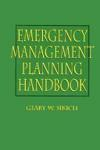

In [ ]:
for imgs, _ in tf_train_set.take(1):
    display(tensor_to_image(imgs[0]))


In [ ]:
# del df # ???

## Model space definition

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Rescaling, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision
import keras_tuner as kt
from functools import reduce

mixed_precision.set_global_policy('mixed_float16')

print(f"Compute dtype: {mixed_precision.global_policy().compute_dtype}")
print(f"Variable dtype: {mixed_precision.global_policy().variable_dtype}")

Compute dtype: float16
Variable dtype: float32


In [ ]:
INPUT_SHAPE = (*IMAGE_SIZE, 3)
EPOCHS = 15

def model_builder(hp):

    hp_units = 256
    hp_filters = hp.Choice('filters', values=[24, 32, 40])
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-4, 5e-4, 1e-3])
    hp_optimizer = "adam" # hp.Choice("optimizer", values=["adam"])

    model = Sequential([
        Input(shape=INPUT_SHAPE, name="input"),
        *reduce(lambda acc, i: acc + [
            Conv2D(
                filters = hp_filters + (0 if i < 1 else 16 * pow(2, i-1)),
                kernel_size = (5 if i < 1 else 3),
                padding = "same",
                kernel_regularizer = l2(1e-4),
                kernel_initializer = GlorotUniform(SEED)
            ),
            BatchNormalization(),
            Activation("relu"),
            MaxPooling2D()
        ], range(3), []),

        Flatten(),
        Dropout(0.3),

        *reduce(lambda acc, i: acc + [
            Dense(hp_units // pow(2, i), activation="relu", kernel_regularizer=l2(1e-4), kernel_initializer = GlorotUniform(SEED)),
            Dropout(0.3),
        ], range(2), []),

        Dense(N_CLASSES, activation="softmax")
    ])

    custom_compile = lambda model, optimizer : model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    optimizer_table = {
        "adam": Adam(learning_rate=hp_learning_rate)
    }

    custom_compile(model, optimizer_table[hp_optimizer])

    return model

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0") # tf.distribute.MirroredStrategy in a multi-GPU scenario

In [ ]:
!rm -r tuners

rm: cannot remove 'tuners': No such file or directory


## Model selection

In [ ]:
# !rm -r models; rm -r checkpoints; rm -r backup

In [ ]:
MODELS_FOLDER = "models/"
MODEL_FILEPATH = MODELS_FOLDER + "model.keras"

In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [ ]:
tuner = kt.GridSearch(
    model_builder,
    objective="val_accuracy",
    directory="tuners",
    project_name="amd_project",
    distribution_strategy=strategy
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Choice)
{'default': 24, 'conditions': [], 'values': [24, 32, 40], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0005, 0.001], 'ordered': True}


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3),
]

if not os.path.exists(MODEL_FILEPATH):
    tuner.search(tf_train_set, validation_data=tf_validation_set, epochs=EPOCHS, callbacks=callbacks)

Trial 9 Complete [00h 04m 18s]
val_accuracy: 0.11032196879386902

Best val_accuracy So Far: 0.24195075035095215
Total elapsed time: 00h 40m 16s


In [ ]:
if not os.path.exists(MODEL_FILEPATH):
    best_hps = tuner.get_best_hyperparameters()[0]

    for p in best_hps.values:
        print(f"{p}: {best_hps.get(p)}")

filters: 40
learning_rate: 0.0001


## Definitive model training and evaluation

In [ ]:
model = None

with strategy.scope():
    if os.path.exists(MODEL_FILEPATH):
        model = load_model(MODEL_FILEPATH)
        print("Model loaded")
    else:
        model = tuner.hypermodel.build(best_hps)
        os.makedirs(MODELS_FOLDER, exist_ok=True)
        model.save(MODEL_FILEPATH)
    model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 100, 150, 40)   │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 150, 40)   │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100, 150, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 75, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 75, 56)     │        20,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 75, 56)     │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 50, 75, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 37, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 37, 72)     │        36,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 37, 72)     │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 25, 37, 72)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 18, 72)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,981,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,076,300 (15.55 MB)

 Trainable params: 4,075,964 (15.55 MB)

 Non-trainable params: 336 (1.31 KB)

In [ ]:
EPOCHS = 150

CHECKPOINTS_PATH = "checkpoints/checkpoint.keras"
BACKUP_PATH = "backup/"

callbacks=[
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=10, restore_best_weights=True),
    ModelCheckpoint(CHECKPOINTS_PATH, save_freq="epoch", monitor='val_accuracy', mode='max', save_best_only=True),
    BackupAndRestore(BACKUP_PATH, save_freq=32, delete_checkpoint=True)
]

history = model.fit(tf_train_set, validation_data=tf_validation_set, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.0934 - loss: 2.7429 - val_accuracy: 0.0940 - val_loss: 2.5619
Epoch 2/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.1128 - loss: 2.5494 - val_accuracy: 0.1080 - val_loss: 2.5538
Epoch 3/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.1177 - loss: 2.5275 - val_accuracy: 0.1290 - val_loss: 2.5256
Epoch 4/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.1381 - loss: 2.4956 - val_accuracy: 0.1432 - val_loss: 2.4798
Epoch 5/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.1477 - loss: 2.4615 - val_accuracy: 0.1636 - val_loss: 2.4479
Epoch 6/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.1626 - loss: 2.4314 - val_accuracy: 0.1475 - val_loss: 2.5347
Epoch 7/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.1705 - loss: 2.4050 - val_accuracy: 0.1960 - val_loss: 2.3630
Epoch 8/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.1749 -

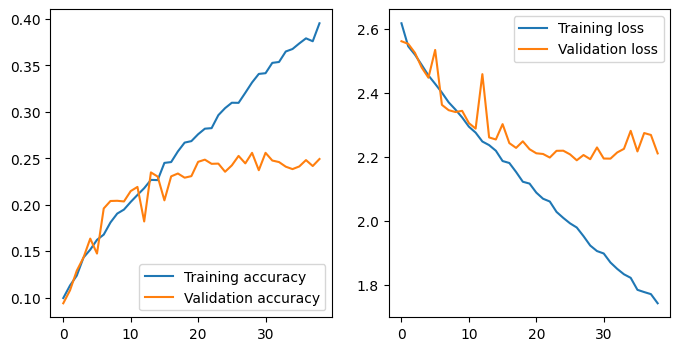

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

xs = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(xs, acc, label='Training accuracy')
plt.plot(xs, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(xs, loss, label='Training loss')
plt.plot(xs, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
eval_result = model.evaluate(tf_test_set)
print(f"Test accuracy: {eval_result[1]:.4}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.2552 - loss: 2.1917
Test accuracy: 0.2583


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


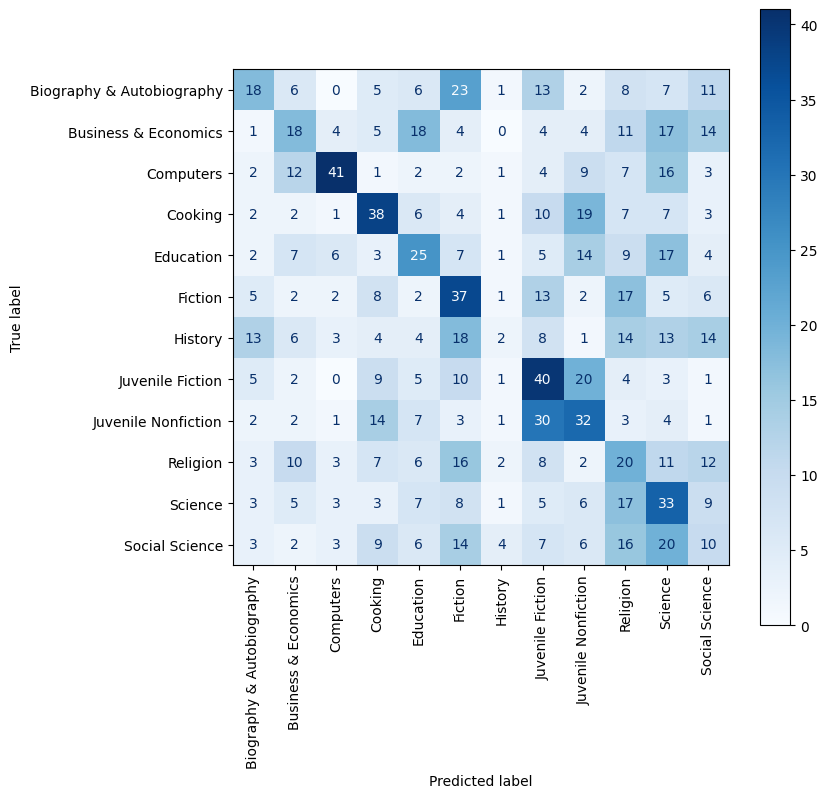

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tf_test_set_copy = tf_test_set.take(12).unbatch()

n_examples = 1200 # 100 per class
cat_count = dict.fromkeys(list(range(12)), 0)

i = 0
xs, ys = np.empty((n_examples, 150, 100, 3)), np.empty((n_examples))
for x, y in tf_test_set_copy:
    cat = y.numpy().astype(int).tolist().index(1)
    if cat_count[cat] < 100:
        xs[i] = x
        ys[i] = cat
        i += 1
        cat_count[cat] += 1

ys_pred = np.argmax(model.predict(xs), axis=1)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ys, ys_pred), display_labels=categories_names)

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(xticks_rotation='vertical', ax=ax, cmap='Blues')
plt.show()

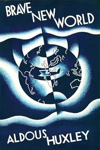

[('Juvenile Fiction', '0.1237'),
 ('Fiction', '0.1158'),
 ('Biography & Autobiography', '0.09877')]

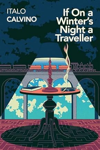

[('Science', '0.1085'),
 ('Education', '0.09575'),
 ('Social Science', '0.09448')]

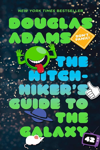

[('Fiction', '0.2041'),
 ('Juvenile Fiction', '0.1491'),
 ('Juvenile Nonfiction', '0.08967')]

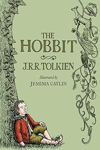

[('Fiction', '0.1846'),
 ('Biography & Autobiography', '0.1374'),
 ('Juvenile Fiction', '0.1286')]

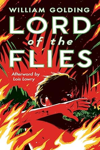

[('Cooking', '0.4616'),
 ('Juvenile Nonfiction', '0.1978'),
 ('Juvenile Fiction', '0.1787')]

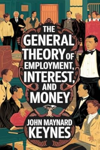

[('Business & Economics', '0.1749'),
 ('Religion', '0.1481'),
 ('Education', '0.1183')]

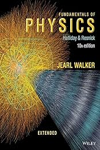

[('Religion', '0.1346'), ('Social Science', '0.1255'), ('Fiction', '0.1239')]

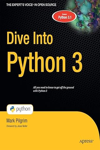

[('Computers', '0.5677'),
 ('Business & Economics', '0.2508'),
 ('Education', '0.08814')]

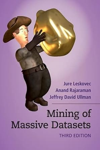

[('Religion', '0.1203'),
 ('History', '0.1069'),
 ('Biography & Autobiography', '0.1025')]

In [ ]:
def predict_by_url(url):
    pred = model.predict(tf.expand_dims(image_from_url(url), axis=0) / 255, verbose=0)[0]
    sorted_idx = np.argsort(pred)[::-1]
    display(
        image_from_url(url),
        [(one_hot_to_str(tf.one_hot(i, depth=N_CLASSES)), f"{float(pred[i]):0.4}" ) for i in sorted_idx[:3]],
    )
    print("\n")


urls = [
    "https://m.media-amazon.com/images/I/51+LdmavGXL._SY445_SX342_.jpg",
    "https://m.media-amazon.com/images/I/5153uAhJyuL._SY445_SX342_.jpg",
    "https://m.media-amazon.com/images/I/71i2fm1QJQL._UF1000,1000_QL80_.jpg",
    "https://m.media-amazon.com/images/I/71UZKQ3-wCL._AC_UL320_.jpg",
    "https://m.media-amazon.com/images/I/716MU3GOvJL._SY522_.jpg",
    "https://m.media-amazon.com/images/I/51kGHMSfuTL._SY445_SX342_.jpg"
    "https://m.media-amazon.com/images/I/61Gic-6egZL._SY425_.jpg",
    "https://m.media-amazon.com/images/I/81+lwBghWBL._AC_UY218_.jpg",
    "https://m.media-amazon.com/images/I/61Gic-6egZL._SY425_.jpg",
    "https://m.media-amazon.com/images/I/61XR7x407zL._SY425_.jpg",
]

for url in urls: predict_by_url(url)